In [1]:
import os, sys
import numpy as np
from astropy import units
from astropy.io import fits
from astropy import constants
from astropy.time import Time
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.table import Column
from scipy.interpolate import interp1d

from matplotlib import colors

parula=np.load('/Users/belugawhale/parula_colors.npy', allow_pickle=True)
#turbo=np.load('/Users/belugawhale/turbo_hex.npy', allow_pickle=True)

### HARPS-N spectra

In [4]:
harps_directory = '/Users/belugawhale/Documents/AUMic/harps-n/'
harps_files = np.sort([os.path.join(harps_directory, i) for i in 
                       os.listdir(harps_directory) if i.endswith('.fits')])

In [3]:
harps_data_cube = np.full((3, len(harps_files), 400000), np.nan)

for i in range(len(harps_files)):
    hdu = fits.open(harps_files[i])
    l = len(hdu[1].data[0]['WAVE'])
    harps_data_cube[0][i][:l] = hdu[1].data[0]['WAVE']+0.0
    harps_data_cube[1][i][:l] = hdu[1].data[0]['FLUX']+0.0
    harps_data_cube[2][i][:l] = hdu[1].data[0]['ERR']+0.0
    hdu.close()

In [4]:
# Need to interpolate onto the same wavelength grid to combine
start = np.nanmax(harps_data_cube[0][:,0])

es = np.zeros(len(harps_files))
for i in range(len(harps_files)):
    q = np.isnan(harps_data_cube[0][i])==False
    es[i] = harps_data_cube[0][i][q][-1]
end = np.nanmin(es)

In [5]:
harps_wavelength = np.flip(np.logspace(np.log10(end), np.log10(start), 310000))[1:-1]

In [6]:
harps_spectra = np.zeros((len(harps_files), len(harps_wavelength)))
for i in range(len(harps_files)):
    interp = interp1d(harps_data_cube[0][i], harps_data_cube[1][i])
    harps_spectra[i] = interp(harps_wavelength)
#harps_spectra = np.nanmedian(harps_spectra, axis=0)

(0.9, 3.0)

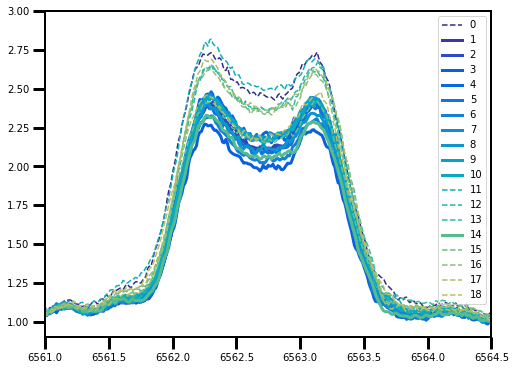

In [38]:
plt.figure(figsize=(8,6))

quality = np.zeros(len(harps_spectra))

for i in range(len(harps_spectra)):
    q = (harps_wavelength > 6545) & (harps_wavelength < 6580)
    
    normreg = ( ((harps_wavelength > 6560) &  (harps_wavelength < 6561.5)) |
                ((harps_wavelength > 6564.5) &  (harps_wavelength < 6566)) )
    
    norm =  harps_spectra[i][q]/np.nanmean(harps_spectra[i][normreg])
    
    if np.nanmax(norm) >= 2.5 or i == 18 or i==15:
        linestyle='--'
        lw=1.5
        quality[i] = 1
    elif np.nanmax(norm) < 2.5:
        linestyle='-'
        lw=3
    
    plt.plot(harps_wavelength[q], norm,
                c=parula[i*10], lw=lw, linestyle=linestyle,label=i)
plt.xlim(6561,6564.5)
plt.legend()
plt.ylim(0.9,3)

In [42]:
len(np.where(quality==0)[0])

11

In [43]:
np.save('harps_spectra.npy', [harps_wavelength, harps_spectra, quality])

/Users/arcticfox/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


### FUSE spectra

In [44]:
fuse_directory = '/Users/arcticfox/Documents/AUMic/fuse/'
fuse_files = np.sort(np.unique([os.path.join(fuse_directory, i) for i in 
                      os.listdir(fuse_directory) if i.endswith('ttagfcal.fit')]))
#fuse_spectra_files = np.array([fuse_files[0],fuse_files[10]])
#fuse_files = np.delete(fuse_files,[0,10])

In [45]:
fuse_wave_cube = np.zeros((4, 44, 30000))
fuse_flux_cube = np.zeros((4, 44, 30000))

tags = ['alif', 'asic', 'blif', 'bsic']

times = np.zeros((4,44,2), dtype='U40')

for j in range(len(tags)):
    ff = np.sort([i for i in fuse_files if tags[j] in i])

    for i in range(len(ff)):
        hdu = fits.open(ff[i])
        t = hdu[0].header['EXPSTART']

        times[j][i][0] = str(Time(hdu[0].header['EXPSTART'], format='mjd').datetime)
        times[j][i][1] = str(Time(hdu[0].header['EXPEND'], format='mjd').datetime)

        fuse_wave_cube[j][i][:len(hdu[1].data['WAVE'])] = hdu[1].data['WAVE']
        fuse_flux_cube[j][i][:len(hdu[1].data['FLUX'])] = hdu[1].data['FLUX']

        hdu.close()

In [46]:
inds = [[0,18],[1,19]]

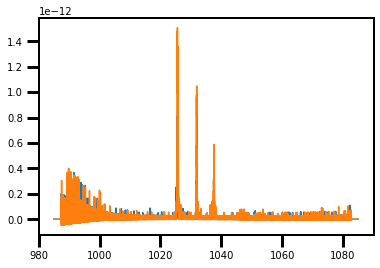

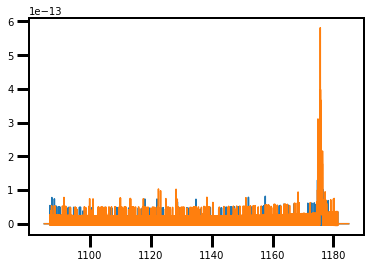

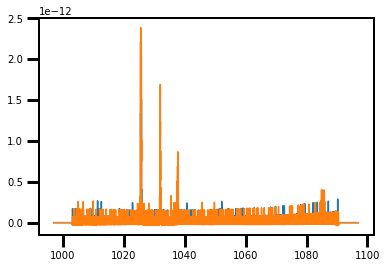

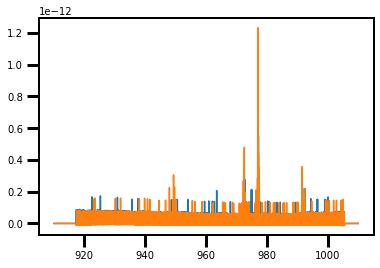

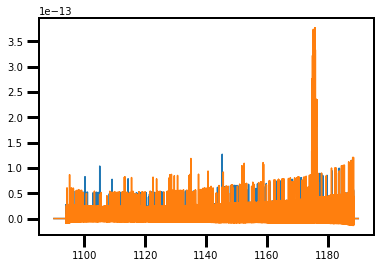

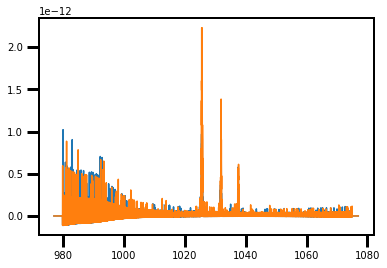

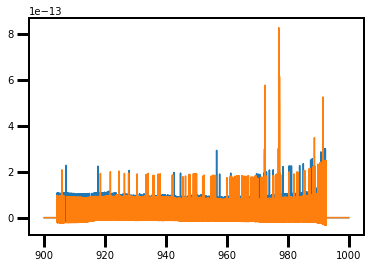

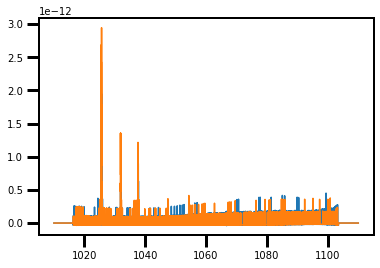

In [47]:
interp_wave = np.zeros((4,4,7700-2))
interp_flux = np.zeros((4,4,7700-2))

for j in range(len(tags)):
    w, f = [], []
    minw, maxw = [], []
    
    for i in range(len(inds)):
        q = fuse_wave_cube[j][inds[i][0]]>0
        plt.plot(fuse_wave_cube[j][inds[i][0]][q], fuse_flux_cube[j][inds[i][0]][q])
        w.append(fuse_wave_cube[j][inds[i][0]][q])
        f.append(fuse_flux_cube[j][inds[i][0]][q])
        
        minw.append(np.nanmin(fuse_wave_cube[j][inds[i][0]][q]))
        maxw.append(np.nanmax(fuse_wave_cube[j][inds[i][0]][q]))
        
        q = fuse_wave_cube[j][inds[i][1]]>0 
        plt.plot(fuse_wave_cube[j][inds[i][1]][q], fuse_flux_cube[j][inds[i][1]][q])
        w.append(fuse_wave_cube[j][inds[i][1]][q])
        f.append(fuse_flux_cube[j][inds[i][1]][q])
        plt.show()
    
        minw.append(np.nanmin(fuse_wave_cube[j][inds[i][1]][q]))
        maxw.append(np.nanmax(fuse_wave_cube[j][inds[i][1]][q]))
    
    neww1 = np.logspace(np.log10(np.nanmax(minw[:2])), 
                        np.log10(np.nanmin(maxw[:2])), 7700)[1:-1]
    neww2 = np.logspace(np.log10(np.nanmax(minw[2:])), 
                        np.log10(np.nanmin(maxw[2:])), 7700)[1:-1]
    
    for i in range(len(w)):
        itrp = interp1d(w[i], f[i])
        if i < 2:
            interp_wave[j][i] = neww1
            interp_flux[j][i] = itrp(neww1)
        else:
            interp_wave[j][i] = neww2
            interp_flux[j][i] = itrp(neww2)

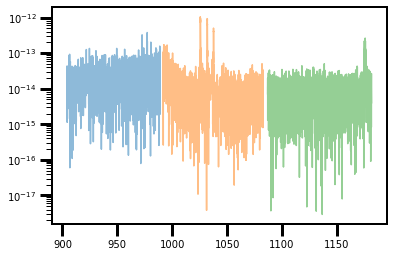

In [48]:
finalw, finalf = np.array([]), np.array([])

for i in [3,0]:
    q = np.nanmean(interp_flux[i][:2],axis=0)>0
    if i == 0:
        cutends = 130
        plt.plot(interp_wave[i][0][q][cutends:], 
                 np.nanmean(interp_flux[i][:2],axis=0)[q][cutends:],
                 alpha=0.5)
        finalw = np.append(finalw, interp_wave[i][0][q][cutends:])
        finalf = np.append(finalf, np.nanmean(interp_flux[i][:2],axis=0)[q][cutends:])
    else:
        cutends=130
        plt.plot(interp_wave[i][0][q][:-cutends], 
                 np.nanmean(interp_flux[i][:2],axis=0)[q][:-cutends],
                 alpha=0.5)
        finalw = np.append(finalw, interp_wave[i][0][q][:-cutends])
        finalf = np.append(finalf, np.nanmean(interp_flux[i][:2],axis=0)[q][:-cutends])    
    if i != 3:
        q = np.nanmean(interp_flux[i][2:],axis=0)>0
        plt.plot(interp_wave[i][2][q], np.nanmean(interp_flux[i][2:],axis=0)[q],alpha=0.5)
        
        finalw = np.append(finalw, interp_wave[i][2][q])
        finalf = np.append(finalf, np.nanmean(interp_flux[i][2:],axis=0)[q])
        
plt.yscale('log')
plt.show()

In [49]:
np.save('fuse_spectra.npy', [finalw, finalf])

### XMM spectra

In [3]:
plt.rcParams['font.size'] = 16

In [4]:
xmm_path = '/Users/arcticfox/Documents/AUMic/'
xmm_file = os.path.join(xmm_path, 'xmm_averaged.FTZ')

In [5]:
hdu = fits.open(xmm_file)

Text(0, 0.5, 's$^{-1}$ cm$^{-2}$ $\\AA^{-1}$')

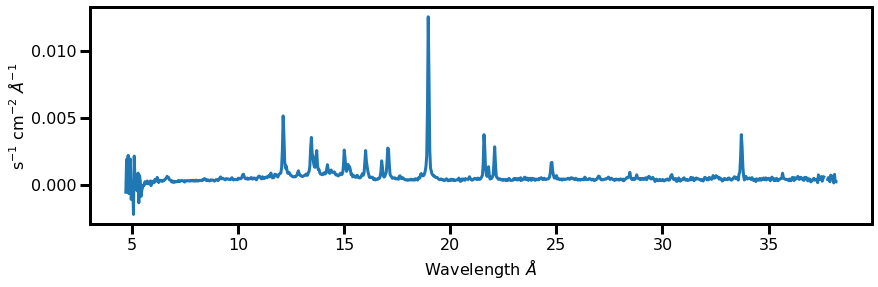

In [6]:
plt.figure(figsize=(14,4))
plt.plot(hdu[1].data['CHANNEL'], hdu[1].data['FLUX'], lw=3)
plt.xlabel('Wavelength $\AA$')
plt.ylabel('s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')

In [9]:
np.save('xmm_spec.npy', [hdu[1].data['CHANNEL'], hdu[1].data['FLUX'], hdu[1].data['ERROR']])

### IUE NUV spectra

In [3]:
iue_path = '/Users/arcticfox/Documents/AUMic/iue/'
iue_files = np.sort([os.path.join(iue_path, i) for i in os.listdir(iue_path)
                     if i.endswith('.mxlo') and 'lwp' in i])

In [8]:
len(iue_files)

20

(1e-14, 1e-12)

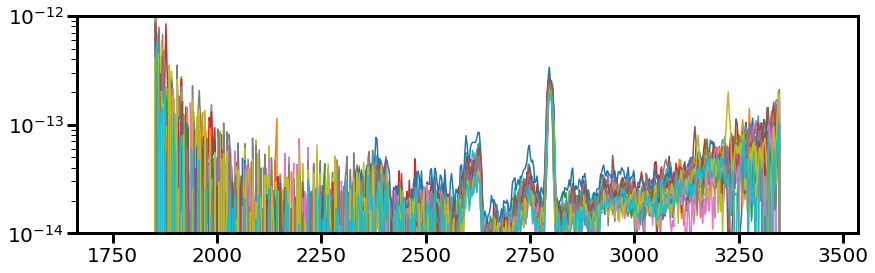

In [4]:
plt.figure(figsize=(14,4))
iue_wave, iue_flux = np.zeros((len(iue_files), 640)), np.zeros((len(iue_files), 640))
iue_qual = np.zeros((len(iue_files), 640))

for i in range(len(iue_files)):
    hdu=fits.open(iue_files[i])
    q = hdu[1].data['QUALITY'][0] == 0

    plt.plot(np.arange(hdu[1].data['WAVELENGTH'], 3452, hdu[1].data['DELTAW']),
                 hdu[1].data['FLUX'][0])

    iue_wave[i] = np.arange(hdu[1].data['WAVELENGTH'], 3452, hdu[1].data['DELTAW'])
    iue_flux[i] = hdu[1].data['FLUX'][0] + 0.0
    iue_qual[i] = hdu[1].data['QUALITY'][0] + 0.0
    
    hdu.close()
plt.yscale('log')
plt.ylim(10e-15, 10e-13)

In [64]:
all_good = np.nansum(iue_qual,axis=0)

In [65]:
iue_med_wave = np.nanmedian(iue_wave, axis=0)[all_good==0]
iue_med_flux = np.nanmedian(iue_flux, axis=0)[all_good==0]

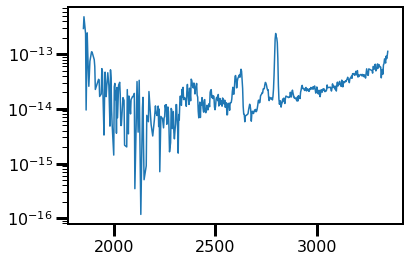

In [66]:
q = iue_med_flux > 0
plt.plot(iue_med_wave[q], iue_med_flux[q])
plt.yscale('log')

## Spitzer Data

In [2]:
mips_path = '/Users/arcticfox/Documents/GitHub/cos_flares/data/'
tab1 = Table.read(os.path.join(mips_path, 'aumic_mips.csv'))
tab_l = Table.read(os.path.join(mips_path, 'lower_x.csv'))
tab_2 = Table.read(os.path.join(mips_path, 'upper_x.csv'))

In [233]:
tab1.add_column(Column(tab1['wavelength_micron']-tab_l['wavelength_micron'], 'lower_x'))
tab1.add_column(Column(tab_2['wavelength_micron']-tab1['wavelength_micron'], 'upper_x'))

newtab = Table()
newtab['wavelength'] = (tab1['wavelength_micron']*units.micron).to(units.AA)
newtab['lower_x'] = (tab1['lower_x']*units.micron).to(units.AA)
newtab['upper_x'] = (tab1['upper_x']*units.micron).to(units.AA)
newtab['flux_density_Jy'] = tab1['flux_density_Jy']

newtab.write('aumic_mips_total.csv', format='csv', overwrite=True)

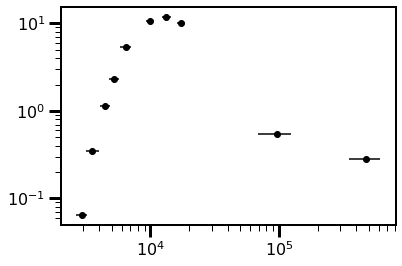

In [234]:
plt.errorbar(newtab['wavelength'], 
             newtab['flux_density_Jy'], 
             xerr=[newtab['lower_x'], 
                   newtab['upper_x']],
             marker='o', linestyle='', color='k')
plt.xscale('log')
plt.yscale('log')

## Phoenix Models

In [2]:
phoenix_files = '/Users/belugawhale/Downloads/lte03700-4.50-0.0.7'

In [4]:
dat = Table.read(phoenix_files,format='ascii')

In [6]:
pwave = np.zeros(len(dat))
pspec = np.zeros(len(dat))

for i in range(len(dat)):
    pwave[i] = float(dat['col1'][i].replace("D", "E"))
    pspec[i] = float(dat['col2'][i].replace("D", "E"))

In [7]:
brks = int(len(pwave)/8)+1

In [8]:
len(pwave[brks*i:brks*(i+1)][1:-3])

0

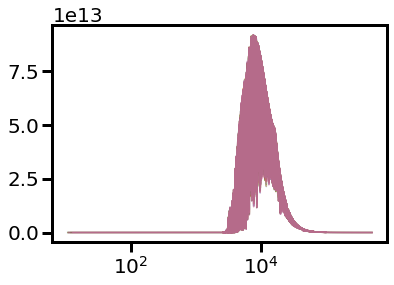

In [9]:
phoenix_grid = np.zeros((2,7,239250))

for i in range(7):
    plt.plot(pwave[brks*i:brks*(i+1)][1:-3],
             10**pspec[brks*i:brks*(i+1)][1:-3],alpha=0.4)
    phoenix_grid[0][i] = pwave[brks*i:brks*(i+1)][1:-3]
    phoenix_grid[1][i] = 10**pspec[brks*i:brks*(i+1)][1:-3]
plt.xscale('log')

In [10]:
np.save('/Users/belugawhale/Documents/GitHub/cos_flares/data/phoenix_grid_3700_4.5_0.0.npy', phoenix_grid)

# Plot all together

In [35]:
COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

In [3]:
dpath = '/Users/belugawhale/Documents/GitHub/cos_flares/data/'
harps_wavelength, harps_spectra, harps_qual = np.load(os.path.join(dpath,'harps_spectra.npy'), 
                                          allow_pickle=True)

#phoenix_grid = np.load('phoenix_grid_3500_4.5_0.0.npy', allow_pickle=True)

cos_quiescent = Table.read(os.path.join(dpath,'quiescent_feinstein.txt'),format='csv')
cos_flare = Table.read(os.path.join(dpath,'flareB_feinstein.txt'),format='csv')

iue_wave, iue_flux, iue_qual = np.load('../data/iue_spectra.npy', allow_pickle=True)
all_good = np.nansum(iue_qual,axis=0)
iue_med_wave = np.nanmedian(iue_wave, axis=0)[all_good==0]
iue_med_flux = np.nanmedian(iue_flux, axis=0)[all_good==0]

fuse_wavelength, fuse_spectra = np.load(os.path.join(dpath,'fuse_spectra.npy'), 
                                        allow_pickle=True)

xmm_wavelength, xmm_spectra, xm_err = np.load(os.path.join(dpath, 'xmm_spec.npy'),
                                              allow_pickle=True)

mips = Table.read(os.path.join(dpath, 'aumic_mips_total.csv'), format='csv')

phoenix_grid = np.load(os.path.join(dpath, 'phoenix_grid_3700_4.5_0.0.npy'), allow_pickle=True)

dpath = '/Users/belugawhale/Documents/AUMic/final_dem_fits/gd/'
dem_f = fits.open(os.path.join(dpath, 'flare/spectrum_au_mic_f_p17.fits'))
dem_q = fits.open(os.path.join(dpath, 'quiescent/spectrum_au_mic_q_p17.fits'))

lyalpha = Table.read('../data/AUMic_E140M_LyA_reconstruction_Sep2020.txt', format='ascii')
lyalpha = lyalpha[4:-4] 
lyalpha['flux'] -= 8e-15

bandpasses = Table.read('/Users/belugawhale/Downloads/wpd_datasets.csv', format='csv')

In [4]:
def bin_dem(bins, wave, flux):

    binw, binf = np.array([]), np.array([])
    lowlim, upplim = np.array([]), np.array([])
    
    for i in range(len(bins)-1):
        inds = np.where((wave>=bins[i]) & (wave < bins[i+1]) &
                        (flux>1e-19))[0]
        med = np.nanmean(flux[inds])
        binw = np.append(binw, wave[inds])
        binf = np.append(binf, np.full(len(inds), med))
        lowlim = np.append(lowlim, np.full(len(inds), np.nanstd(flux[inds])))
        upplim = np.append(upplim, np.full(len(inds), np.nanstd(flux[inds])))
            
    return binw, binf, lowlim, upplim

In [5]:
def bb(wavelength, T):
    frac = (2 * constants.h * constants.c**2) / wavelength**5
    exp = (constants.h * constants.c) / (wavelength * constants.k_B * T)
    bfunc = frac * 1.0/(np.exp(exp) - 1.0)
    return bfunc.to(units.erg/units.cm**2/units.s/units.AA)

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_69547/3282868090.py:88: RuntimeWarning: overflow encountered in power
  pan_wavelength = np.append(pan_wavelength, 10**harps_wavelength[q][1000:])
/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_69547/3282868090.py:142: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(path, name), dpi=200,


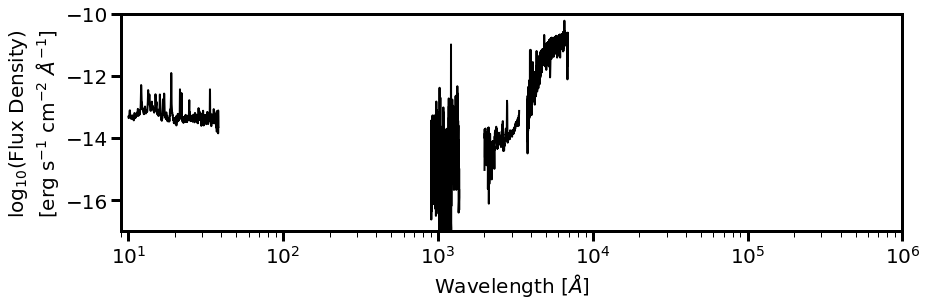

In [43]:
inds = np.array([0+5,  46-20,  92-25, 138-45, 184, 230+10],dtype=int)
lw = 2

pan_wavelength, pan_spectrum = np.array([]), np.array([])

qc='#878482'
fc='#352a87'
highlight = ['darkorange', 'navy']
cs = [COLOR, COLOR, COLOR, COLOR]

labels=['Flare B', 'Quiescent']

tot_wave = np.arange(5,7000,1)*units.AA

fig,ax = plt.subplots(figsize=(14,4), sharex=True, sharey=True)
#fig.set_facecolor('w')


## QUIESCENT XMM AND FUSE
xq = (xmm_spectra > 0) & (xmm_wavelength>10)
ax.plot(xmm_wavelength[xq], 
        np.log10(xmm_spectra[xq]*10**-10), c=cs[1],
         lw=lw)
pan_wavelength = np.append(pan_wavelength, xmm_wavelength[xq])
pan_spectrum   = np.append(pan_spectrum, xmm_spectra[xq]*10**-10)

fq = (fuse_spectra>0)
ax.plot(fuse_wavelength[fq], 
        np.log10(fuse_spectra[fq]/2.5), c=cs[1],
         lw=lw)#, label=labels[1])
pan_wavelength = np.append(pan_wavelength, fuse_wavelength[fq])
pan_spectrum   = np.append(pan_spectrum, fuse_spectra[fq]/2.5)

## DEM
"""
q = ((dem_q[1].data['Wavelength']>xmm_wavelength[xq][-1]) & 
     (dem_q[1].data['Wavelength']<fuse_wavelength[fq][0]))
ax.plot(dem_q[1].data['Wavelength'][q], 
        np.log10(dem_q[1].data['Flux_density'][q]),
        c=cs[2], lw=lw)
ax.axvspan(dem_q[1].data['Wavelength'][q][0], dem_q[1].data['Wavelength'][q][-1],
           0, 10, color='#F4A139',#highlight[0], 
           alpha=0.4, label='DEM Modeled')
pan_wavelength = np.append(pan_wavelength, dem_q[1].data['Wavelength'][q])
pan_spectrum   = np.append(pan_spectrum, dem_q[1].data['Flux_density'][q])
"""

## QUIESCENT COS
cq = cos_quiescent['flux_density']>0
ax.plot(cos_quiescent['wavelength_AA'][cq], 
        np.log10(cos_quiescent['flux_density'][cq]),
        c=cs[1], lw=lw)

ax.plot(lyalpha['wavelength'],
        np.log10(lyalpha['flux']), c=cs[1], lw=lw)

pan_wavelength = np.append(pan_wavelength, cos_quiescent['wavelength_AA'][cq])
pan_spectrum   = np.append(pan_spectrum, cos_quiescent['flux_density'][cq])

## IUE
iq = (iue_med_flux > 0) & (iue_med_wave > 2000)
iue_flux = np.log10(iue_med_flux[iq]/1.5)
ax.plot(iue_med_wave[iq], 
        iue_flux, c=cs[1],
         lw=lw)
pan_wavelength = np.append(pan_wavelength, iue_med_wave[iq])
pan_spectrum   = np.append(pan_spectrum, 10**iue_flux)

poly = np.polyfit(np.append(cos_quiescent['wavelength_AA'][cq], iue_med_wave[iq]), 
                  np.append(np.log10(cos_quiescent['flux_density'][cq]), iue_flux), 
                  deg=1)
fit = np.poly1d(poly)
x = np.arange(cos_quiescent['wavelength_AA'][cq][-1], iue_med_wave[iq][0], 0.1)
#ax.plot(x, fit(x), cs[1])

pan_wavelength = np.append(pan_wavelength, x)
pan_spectrum   = np.append(pan_spectrum, 10**fit(x))

## QUIESCENT OPTICAL
q = harps_qual==0
harps_med_spectra = np.nanmean(harps_spectra[q],axis=0)
q = harps_med_spectra > 0
qp = phoenix_grid[0][0] > harps_wavelength[q][-1]
harps_flux = np.log10(harps_med_spectra[q][1000:]/5e14)
ax.plot(harps_wavelength[q][1000:], 
        harps_flux,
        c=cs[1], lw=lw)
pan_wavelength = np.append(pan_wavelength, 10**harps_wavelength[q][1000:])
pan_spectrum   = np.append(pan_spectrum, harps_flux)


poly = np.polyfit(np.append(iue_med_wave[iq], harps_wavelength[q][60000:60002]), 
                  np.append(iue_flux, harps_flux[60000:60002]), 
                  deg=1)
fit = np.poly1d(poly)
x = np.arange(iue_med_wave[iq][-2], harps_wavelength[q][0], 0.1)

#ax.plot(x, fit(x), cs[1])
pan_wavelength = np.append(pan_wavelength, x)
pan_spectrum   = np.append(pan_spectrum, 10**fit(x))

"""
ax.plot(phoenix_grid[0][0][qp], 
        np.log10(phoenix_grid[1][0][qp]/3e24),
        zorder=1, c=cs[3], lw=lw)
ax.axvspan(phoenix_grid[0][0][qp][0], phoenix_grid[0][0][qp][-1],
           0, 10, color='#B3B3B3',#highlight[1], 
           alpha=0.4, label='Phoenix Model')
"""

pan_wavelength = np.append(pan_wavelength, phoenix_grid[0][0][qp])
pan_spectrum   = np.append(pan_spectrum, phoenix_grid[1][0][qp]/4.5e25)

"""
ax.errorbar((np.array([24, 70])*units.micron).to(units.AA).value,
            np.log10(np.array([0.148, 0.22899])/1e14),
             xerr=[mips['lower_x'][-2:], mips['upper_x'][-2:]],
             markeredgecolor=COLOR, linestyle='', color='w',
             marker='o', label='Spitzer', ecolor=COLOR, ms=8)
"""

##########################
##### plot logistics #####
##########################

ax.set_xlabel('Wavelength [$\AA$]')
ax.set_ylabel('log$_{10}$(Flux Density)\n[erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')#,y=1.1)

plt.xlim(9,1e6)

#lgd = plt.legend(bbox_to_anchor=(0, 1.01, 1., .05), loc=3, frameon=False,
#                 ncol=4,  borderaxespad=0., fontsize=18, mode='expand')
#for handle in lgd.legendHandles[:-1]:
#    handle.set_linewidth(0)

plt.xscale('log')
plt.ylim(-17,-10)
path = '/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/light-bkg/'
name = 'panchromatic_observations.png'
save = True
if save:
    plt.savefig(os.path.join(path, name), dpi=200,
                rasterize=True, bbox_inches='tight',
                transparent=True)

In [95]:
argsort = np.argsort(pan_wavelength)
tab = Table()
q = np.isfinite(pan_wavelength[argsort])==True
tab['wavelength_AA'] = pan_wavelength[argsort][q] + 0.0
tab['flux_density_erg_s_cm2_AA'] = pan_spectrum[argsort][q] + 0.0

In [87]:
#tab.write('/Users/arcticfox/Desktop/au_mic_quiescent_panchromatic.txt', format='csv')

In [96]:
inds = np.where((tab['wavelength_AA']>=lyalpha['wavelength'][0]) &
                (tab['wavelength_AA']<=lyalpha['wavelength'][-1]))

pan_spectrum = np.delete(pan_spectrum, inds)
pan_wavelength = np.delete(pan_wavelength, inds)

pan_spectrum = np.append(pan_spectrum, lyalpha['flux'])
pan_wavelength = np.append(pan_wavelength, lyalpha['wavelength'])

In [97]:
argsort = np.argsort(pan_wavelength)
tab = Table()
q = np.isfinite(pan_wavelength[argsort])==True
tab['wavelength_AA'] = pan_wavelength[argsort][q] + 0.0
tab['flux_density_erg_s_cm2_AA'] = pan_spectrum[argsort][q] + 0.0

(1200.0, 1230.0)

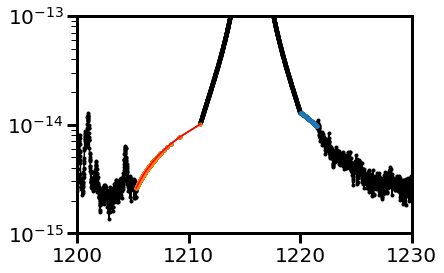

In [176]:
plt.plot(tab['wavelength_AA'], tab['flux_density_erg_s_cm2_AA'], 'k', marker='.')
inds = np.where((tab['wavelength_AA']>lyalpha['wavelength'][-1]) &
                (tab['wavelength_AA']<1221.5))[0]
plt.plot(tab['wavelength_AA'][inds], tab['flux_density_erg_s_cm2_AA'][inds], marker='.')

x = np.array(tab['wavelength_AA'][inds])
poly = np.polyfit(np.append(x[0], x[-1]),
                  np.append(tab['flux_density_erg_s_cm2_AA'][inds-2][0], 
                            tab['flux_density_erg_s_cm2_AA'][inds+2][-1]),                  
                  deg=1)
fit = np.poly1d(poly)

tab['flux_density_erg_s_cm2_AA'][inds] = fit(x)

inds = np.where((tab['wavelength_AA']>1205.3) &
                (tab['wavelength_AA']<=lyalpha['wavelength'][0]))[0]
plt.plot(tab['wavelength_AA'][inds], tab['flux_density_erg_s_cm2_AA'][inds], marker='.')
x = np.array(tab['wavelength_AA'][inds])
poly = np.polyfit(np.append(x[0], x[-1]),
                  np.append(tab['flux_density_erg_s_cm2_AA'][inds-2][0], 
                            lyalpha['flux'][0]),
                  deg=1)
fit = np.poly1d(poly)
plt.plot(x, fit(x), 'r')
tab['flux_density_erg_s_cm2_AA'][inds] = fit(x)

plt.yscale('log')
plt.ylim(1e-15, 1e-13)
plt.xlim(1200,1230)

(1150.0, 1280.0)

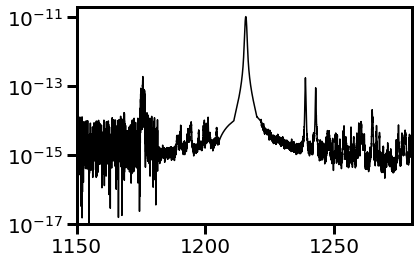

In [191]:
plt.plot(tab['wavelength_AA'], tab['flux_density_erg_s_cm2_AA'], 'k')
plt.yscale('log')
plt.ylim(1e-17,2e-11)
plt.xlim(1150,1280)

In [178]:
tab.write('/Users/arcticfox/Desktop/au_mic_quiescent_panchromatic.txt', format='csv',
          overwrite=True)

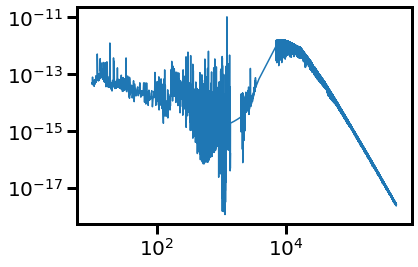

In [180]:
tab = Table.read('/Users/arcticfox/Desktop/au_mic_quiescent_panchromatic.txt', format='csv')
plt.plot(tab['wavelength_AA'], tab['flux_density_erg_s_cm2_AA'])
plt.yscale('log')
plt.xscale('log')

## Rainbow for funsies

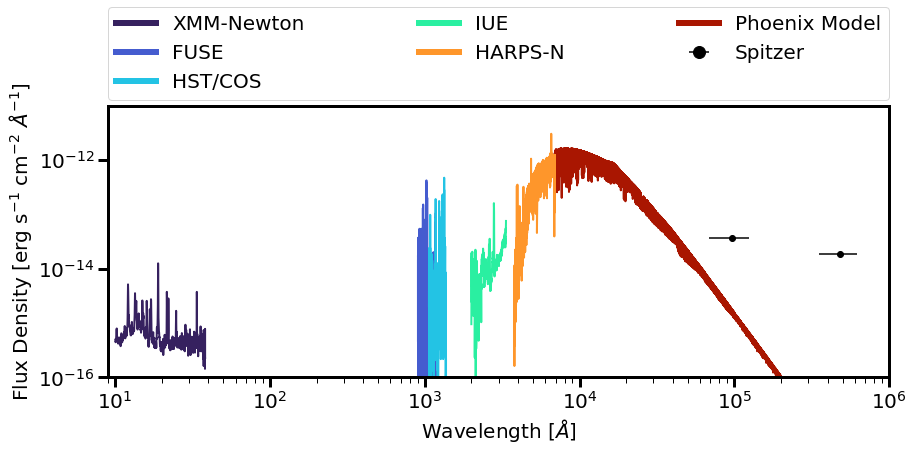

In [14]:
inds = np.array([  0+5,  46-20,  92-25, 138-45, 184, 230+10],dtype=int)
lw = 2

tot_wave = np.arange(5,7000,1)*units.AA

fig = plt.figure(figsize=(14,5))
fig.set_facecolor('w')

q = (xmm_spectra > 0) & (xmm_wavelength>10)
plt.plot(xmm_wavelength[q], xmm_spectra[q]*1e-12, c=turbo[inds[0]], 
         label='XMM-Newton', lw=lw)

q = (fuse_spectra>0)
plt.plot(fuse_wavelength[q], fuse_spectra[q]/2.5, c=turbo[inds[1]],
         label='FUSE', lw=lw)

q = cos_quiescent['flux_density']>0
plt.plot(cos_quiescent['wavelength_AA'][q], cos_quiescent['flux_density'][q],
         c=turbo[inds[2]], label='HST/COS', lw=lw)

#q = cos_flare['flux_density']>0
#plt.plot(cos_flare['wavelength_AA'][q], cos_flare['flux_density'][q], '--')

q = (iue_med_flux > 0) & (iue_med_wave > 2000)
plt.plot(iue_med_wave[q], iue_med_flux[q]/1.5, c=turbo[inds[3]], 
         label='IUE', lw=lw)

q = harps_qual==0
harps_med_spectra = np.nanmean(harps_spectra[q],axis=0)
q = harps_med_spectra > 0
plt.plot(harps_wavelength[q][1000:], 
         harps_med_spectra[q][1000:]/1e16, c=turbo[inds[4]],
         label='HARPS-N', lw=lw)

plt.errorbar(mips['wavelength'][-2:], mips['flux_density_Jy'][-2:]/1.5e13,
             xerr=[mips['lower_x'][-2:], mips['upper_x'][-2:]],
             color='k', linestyle='',
             marker='o', label='Spitzer')

q = phoenix_grid[0][0] > harps_wavelength[q][-1]
#plt.plot(phoenix_grid[0][0], phoenix_grid[1][0]/4.5e23,zorder=1,
#         c=turbo[inds[5]], alpha=0.3)
plt.plot(phoenix_grid[0][0][q], phoenix_grid[1][0][q]/4.5e25,
         zorder=1,c=turbo[inds[5]], label='Phoenix Model', lw=lw)

plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux Density [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

plt.yscale('log')
plt.ylim(10e-17,10e-12)
plt.xlim(9,1e6)
leg = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0.)

for line in leg.get_lines():
    line.set_linewidth(6)

    
plt.xscale('log')
#plt.savefig('/Users/arcticfox/Documents/AUMic/paper/panchromatic.png', dpi=200,
#            rasterize=True, bbox_inches='tight');

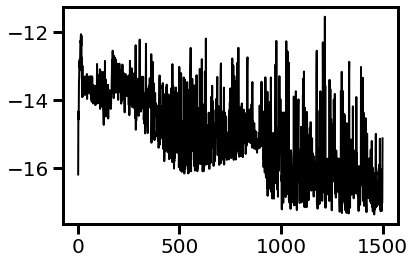

In [8]:
plt.plot(dem_q[1].data['Wavelength'], 
        np.log10(dem_q[1].data['Flux_density']),
        c=cs[2], lw=lw)

In [24]:
q = dem_q[1].data['Wavelength'] < 900
distance = (9.72*units.pc).to(units.cm)
np.trapz(dem_q[1].data['Flux_density']*units.erg/units.cm**2/units.AA/units.s, 
         dem_q[1].data['Wavelength']*units.AA) * 4 * np.pi  * distance**2

<Quantity 3.22885751e+29 erg / s>

In [25]:
distance = (9.72*units.pc).to(units.cm)
np.trapz(dem_f[1].data['Flux_density']*units.erg/units.cm**2/units.AA/units.s, 
         dem_f[1].data['Wavelength']*units.AA) * 4 * np.pi  * distance**2

<Quantity 4.5534449e+29 erg / s>